## Proxy Quantitaive Metrics

### 1. **PSNR (Proxy)** Calculation

In an unsupervised scenario where no clean reference images are available, you can use the **denoised image** as a pseudo-clean image for the calculation of **PSNR** (Peak Signal-to-Noise Ratio). This is often referred to as **pseudo-PSNR**.

#### **Formula:**
$$ 
PSNR = 20 \cdot \log_{10}\left(\frac{\text{MAX}_{I}}{\sqrt{\text{MSE}}}\right)
$$
Where:
- $\text{MAX}_{I}$ is the maximum possible pixel value of the image (255 for 8-bit images, 1 for normalized images).
- $\text{MSE}$ is the Mean Squared Error between the noisy image and the denoised image.

#### **Step-by-Step Calculation:**
1. **Input**: Take the noisy image and the denoised image as inputs.
2. **MSE Calculation**:
   - Calculate the Mean Squared Error (MSE) between the noisy input image and the denoised output image:
    $$
     \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( I_{\text{noisy}}(i) - I_{\text{denoised}}(i) \right)^2
     $$
     Where $ N $ is the total number of pixels, and $ I_{\text{noisy}}(i) $ and $ I_{\text{denoised}}(i) $ represent the pixel values of the noisy and denoised images, respectively.
3. **PSNR Calculation**:
   - Substitute the MSE value into the PSNR formula to compute the **PSNR** value.


In [91]:
import numpy as np

def calculate_psnr(noisy_img, denoised_img):
    #max_pixel_value = np.max(denoised_img)
    max_pixel_value =np.max((np.max(noisy_img), np.max(denoised_img)))
    mse = np.mean((noisy_img - denoised_img) ** 2)
    if mse == 0:
        return float('inf')  # MSE = 0 means the images are identical
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

In [65]:
#Read in the dicom images noisy and denosied
import pydicom

#Gaussian filter
from scipy.ndimage import gaussian_filter

#Read the DICOM image
ds = pydicom.dcmread('LodoxScans/Tools.dcm')

#Extract the file name
file_name = ds.filename

#Print the file name
print(f'File name: {file_name}')

#Strip the extension and folder to only get the file name eg 'LodoxScans/Tools.dcm' to 'Tools'
file_name = file_name.split('/')[-1].split('.')[0]

#Print the file name
print(f'File name: {file_name}')

#Print the image information
#print(ds)



#Get the image data
image = ds.pixel_array

#print the image data type
print(f'Image data type: {image.dtype}')

#Print the shape of the image
print(f'Image shape: {ds.pixel_array.shape}')

#Apply Gaussian filter
sigma = 1
image_denoised = gaussian_filter(image, sigma)

#Calculate the PSNR
psnr_value = calculate_psnr(image, image_denoised)
print(f"PSNR: {psnr_value} dB")


# Update the pixel data in the DICOM object
ds.PixelData = image_denoised.astype(np.uint16).tobytes()  # Ensure correct data type (e.g., uint16)

# Save the modified DICOM file
output_dicom_path = f'LodoxScans/{file_name}_denoised.DCM'

ds.save_as(output_dicom_path)
print(f'Denoised image saved as {output_dicom_path}')


def loadimages(folder):
    images = []
    image_names = []
    for file in glob.glob(folder + '/*.DCM'):
        ds = pydicom.dcmread(file)
        file_name = ds.filename
        file_name = file_name.split('/')[-1].split('.')[0]
        image = ds.pixel_array
        image = np.expand_dims(image, axis=-1)
        image = image.astype(np.float32)
        #image = np.expand_dims(image, axis=0)
        images.append(image)
        image_names.append(file_name)

    return images, image_names


File name: LodoxScans/Tools.dcm
File name: Tools
Image data type: uint16
Image shape: (2720, 3584)
PSNR: 50.99986787311985 dB
Denoised image saved as LodoxScans/Tools_denoised.DCM


### 2. **SSIM (Proxy)** Calculation

In an unsupervised scenario, **SSIM (Structural Similarity Index)** can be calculated between the **noisy image** and the **denoised image** as a proxy for the clean image. SSIM measures the similarity between two images in terms of luminance, contrast, and structure.

#### **Formula:**
$$
SSIM(x, y) = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$
Where:
- $ \mu_x $, $ \mu_y $: Mean intensities of the noisy and denoised images.
- $ \sigma_x^2 $, $ \sigma_y^2 $: Variances of the noisy and denoised images.
- $ \sigma_{xy} $: Covariance between the two images.
- $ C_1 $, $ C_2 $: Small constants to stabilize the division (typically $ C_1 = (0.01 \cdot L)^2 $ and $ C_2 = (0.03 \cdot L)^2 $, where $ L $ is the dynamic range of pixel values).

#### **Step-by-Step Calculation:**
1. **Input**: Take the noisy image and the denoised image.
2. **Local Statistics**:
   - Compute the mean $ \mu_x $, $ \mu_y $, variance $\sigma_x^2 $, $ \sigma_y^2 $, and covariance $ \sigma_{xy} $ for small local windows (e.g., 8x8 pixel windows).
3. **SSIM Calculation**:
   - Use the formula to compute SSIM for each local window.
   - Aggregate the local SSIM values over the entire image to obtain the global SSIM.


In [97]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(noisy_img, denoised_img):
    #convert
    return ssim(noisy_img, denoised_img, data_range=noisy_img.max() - noisy_img.min())




In [12]:
#Calculate the SSIM
ssim_value = calculate_ssim(image, image_denoised)

print(f"SSIM: {ssim_value}")

SSIM: 0.9907019608474584


### **3. SNR (Signal-to-Noise Ratio) Calculation**

In an unsupervised scenario, where there are no clean reference images available, you can calculate the SNR (Signal-to-Noise Ratio) using the denoised image and the noisy image. The SNR helps measure the level of signal compared to the background noise.

#### **Formula**:

$$
SNR = \frac{\mu_{\text{signal}}}{\sigma_{\text{noise}}}
$$

Where:
- $\mu_{\text{signal}}$ is the mean of the denoised image (signal).
- $\sigma_{\text{noise}}$ is the standard deviation of the noise, which is the difference between the noisy input image and the denoised image.

#### **Step-by-Step Calculation**:

1. **Input**: Take the noisy image and the denoised image as inputs.

2. **Noise Calculation**:
   - Calculate the **noise** as the difference between the noisy image and the denoised image:
     $$
     \text{Noise}(i) = I_{\text{noisy}}(i) - I_{\text{denoised}}(i)
     $$
     where $I_{\text{noisy}}(i)$ is the pixel value of the noisy image at index $i$ and $I_{\text{denoised}}(i)$ is the pixel value of the denoised image at index $i$.

3. **Mean Signal Calculation**:
   - Calculate the mean pixel value of the denoised image (signal):
     $$
     \mu_{\text{signal}} = \frac{1}{N} \sum_{i=1}^{N} I_{\text{denoised}}(i)
     $$
     where $N$ is the total number of pixels in the image.

4. **Standard Deviation of Noise**:
   - Calculate the standard deviation of the noise image:
     $$
     \sigma_{\text{noise}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\text{Noise}(i))^2}
     $$

5. **SNR Calculation**:
   - Finally, substitute the mean signal and the standard deviation of noise into the SNR formula to compute the SNR value:
     $$
     SNR = \frac{\mu_{\text{signal}}}{\sigma_{\text{noise}}}
     $$


In [93]:


def calculate_snr(denoised_image, noisy_image):
    """
    Calculate the Signal-to-Noise Ratio (SNR) between a denoised image and a noisy image.
    
    :param denoised_image: numpy array representing the denoised image
    :param noisy_image: numpy array representing the noisy image
    :return: SNR value
    """
    
    # Calculate the noise
    noise = noisy_image - denoised_image
    
    # Calculate the mean of the denoised image (signal)
    signal_mean = np.mean(denoised_image)
    
    # Calculate the standard deviation of the noise
    noise_std = np.std(noise)
    
    # Calculate SNR
    snr = signal_mean / noise_std
    
    return snr




In [15]:
#Calculate the SNR
snr_value = calculate_snr(image_denoised, image)

#experiment reverse the inputs tom observew the snr
snr_value_r = calculate_snr(image, image_denoised)


print(f"SNR: {snr_value} dB")

print(f"SNR_reversed: {snr_value_r} dB")



SNR: 0.23232576614605308 dB
SNR_reversed: 0.23038345642377267 dB


### 4 **Noise Residual Analysis**
**Noise Residual Analysis** is a technique used to evaluate the performance of a denoising model by analyzing the **residual noise**. Residual noise refers to the difference between the noisy input image and the denoised output image. By studying the residual noise, you can identify how well the denoising model is performing and which types of noise (spatial, high-frequency, etc.) remain in the image after denoising. This analysis is crucial in unsupervised denoising tasks where no ground truth clean image is available.

#### **Step-by-Step Approach for Noise Residual Analysis**:

1. **Compute the Noise Residual**:
   - The **residual noise** is the difference between the noisy image and the denoised image:
     $$
     \text{Residual}(i) = I_{\text{noisy}}(i) - I_{\text{denoised}}(i)
     $$
     Here, $I_{\text{noisy}}(i)$ represents the pixel value of the noisy input image, and $I_{\text{denoised}}(i)$ represents the pixel value of the denoised image at pixel index $i$.

2. **Visualize the Noise Residual**:
   - Visualize the residual noise image to identify regions where the model failed to remove noise. Areas with high-intensity values in the residual image indicate regions with a larger amount of remaining noise.
   - You can display the noise residual image as a grayscale image for easy comparison.

3. **Statistical Analysis of Residuals**:
   - Perform statistical analysis on the residual noise to understand its properties. Calculate metrics such as the **mean**, **standard deviation**, and **variance** of the residuals to quantify how much noise remains after denoising.
     - **Mean of Residuals**: Close to 0 indicates that the model is not adding any bias to the image.
     - **Standard Deviation of Residuals**: Lower values indicate that the model successfully removed a significant amount of noise.
     - **Skewness/Kurtosis**: These metrics can give insight into whether the remaining noise follows a Gaussian distribution (desired for many denoising tasks).

4. **Frequency Domain Analysis**:
   - Apply **Fourier Transform** (FFT) to the residuals to analyze the noise in the frequency domain. This helps determine whether the model is effective at removing high-frequency noise components, such as salt-and-pepper noise or Gaussian noise.
   - Compare the power spectra of the noisy image, denoised image, and residual to see where the model is effective or ineffective (e.g., low-frequency components should be preserved, while high-frequency noise should be minimized).

5. **Correlate Residuals with Image Features**:
   - Analyze if residual noise correlates with certain features of the original noisy image (e.g., edges, textures). This is important because some denoising models, especially those trained unsupervised, might mistake important image details (like edges or textures) for noise, leading to over-smoothing.
   - If the residual contains information about edges or important structures, the model may be over-denoising, thus leading to loss of detail.


In [57]:


# Calculate the residual noise
residual = image - image_denoised
#residual = image_denoised - image

# Calculate the mean squared error
mse = np.mean(residual ** 2)

# Print the mean squared error
print(f"Mean Squared Error: {mse}")

# print few values of the residual
print(residual[:5, :5])

Mean Squared Error: 2132.323490431329
[[ 1210  1455 65033 65489   169]
 [64036 65029 64307 65007 65192]
 [ 1733  1878 65332   171   360]
 [64215 65270 64652 65393    40]
 [ 1998  2295 64447 65330 65448]]


1. **Visualize the Noise Residual**:
   - In Python, use libraries like `matplotlib` or `OpenCV` to visualize the residual noise image. A high contrast in certain regions of the residual image could indicate areas where the denoising model struggles.


Text(0.5, 1.0, 'Residual Image')

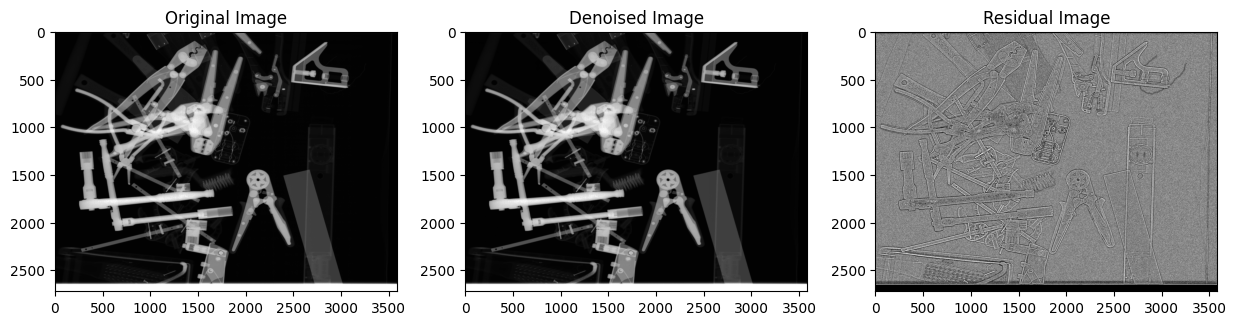

In [54]:
import matplotlib.pyplot as plt

#Viuslaise the image, denoised image and residual
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(image_denoised, cmap='gray')
plt.title('Denoised Image')

plt.subplot(1, 3, 3)
plt.imshow(residual, cmap='gray')
plt.title('Residual Image')

2. **Statistical Analysis**:
   - Use `numpy` or `scipy` to calculate the mean, variance, skewness, and kurtosis of the residual noise to quantify the noise left in the image.

In [55]:
import numpy as np
from scipy.stats import skew, kurtosis

#Display the range of values in the orginal image
print(f"Min: {np.min(image)}, Max: {np.max(image)}")

#Display the range of values in the denoised image
print(f"Min: {np.min(image_denoised)}, Max: {np.max(image_denoised)}")

#Display the range of values in the residual image
print(f"Min: {np.min(residual)}, Max: {np.max(residual)}")


# Residual noise statistics
mean_residual = np.mean(residual)
std_residual = np.std(residual)
skewness = skew(residual.flatten())
kurt_value = kurtosis(residual.flatten())

print(f"Mean: {mean_residual}, Std Dev: {std_residual}, Skewness: {skewness}, Kurtosis: {kurt_value}")

Min: 5762, Max: 16384
Min: 5779, Max: 16384
Min: 0, Max: 65535
Mean: 32711.81910800453, Std Dev: 32743.79408338931, Skewness: 0.00337031742623983, Kurtosis: -1.999976668152614


3. **Frequency Domain Analysis**:
   - Use **Fourier Transform** (FFT) to analyze the frequency components of the residual noise. By transforming both the noisy and residual images into the frequency domain, you can evaluate which frequencies the model effectively removed and which remain.

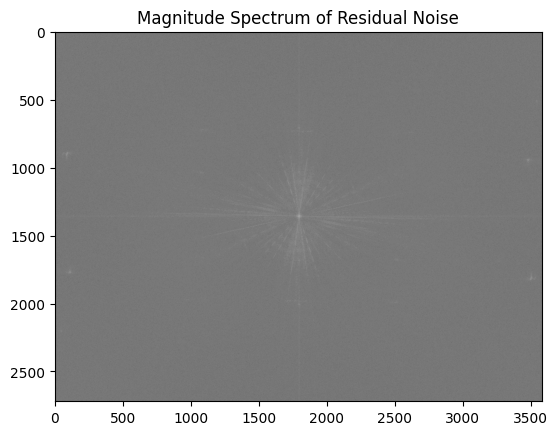

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Compute FFT of residual
residual_fft = np.fft.fftshift(np.fft.fft2(residual))

# Compute magnitude spectrum
magnitude_spectrum = np.log(np.abs(residual_fft) + 1)

# Visualize the magnitude spectrum
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of Residual Noise')
plt.show()


4. **Error Map Analysis**:
   - Another pragmatic approach to residual analysis is computing **error maps** (heatmaps that visualize the error in terms of residuals). These maps highlight where the most significant differences (noise) remain, allowing for a deeper understanding of model performance in different regions of the image.


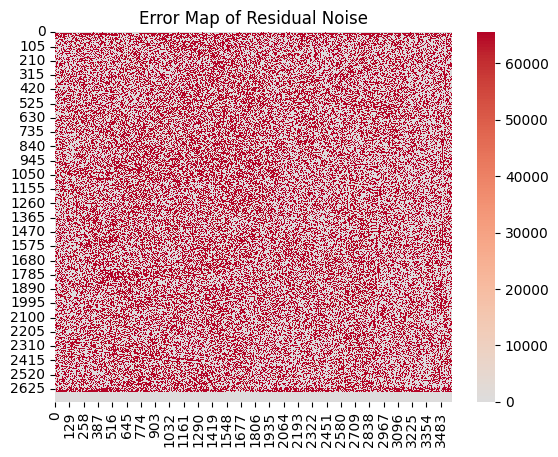

In [45]:
import seaborn as sns

# Visualize an error map of the residuals
sns.heatmap(residual, cmap='coolwarm', center=0)
plt.title('Error Map of Residual Noise')
plt.show()


## 2. No-Reference Image Quality Metrics

### 3.1. BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator)
- BRISQUE evaluates image quality based on distortion-sensitive features from local image patches.
- A lower BRISQUE score indicates better quality.

In [20]:
from brisque import BRISQUE
import cv2

def calculate_brisque(image):
    """
    Calculate the BRISQUE score for an image.
    
    :param image: numpy array representing the image
    :return: BRISQUE score
    """

    # Create a BRISQUE object
    brisque = BRISQUE()

    #Convert to 3-channel image as BRISQUE expects a 3-channel image
    #image = np.stack((image, image, image), axis=-1)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Calculate BRISQUE score
    brisque_score = brisque.score(image)
    
    return brisque_score




In [21]:
#Calculate the BRISQUE score
brisque_score_noisy = calculate_brisque(image)
brisque_score_denoised = calculate_brisque(image_denoised)

print(f"BRISQUE score (noisy): {brisque_score_noisy}")
print(f"BRISQUE score (denoised): {brisque_score_denoised}")

BRISQUE score (noisy): 110.40130680853574
BRISQUE score (denoised): 118.38722504637346


#### 3.2. NIQE (Natural Image Quality Evaluator)
- NIQE is a "completely blind" image quality metric that computes quality by comparing natural scene statistics with model-based features.
- A lower NIQE score indicates better image quality.

In [69]:
import matlab.engine

In [70]:
# Start MATLAB engine
eng = matlab.engine.start_matlab()

In [71]:
def calculate_niqe_matlab(image):
    """
    Calculate the NIQE score for an image using MATLAB.
    
    :param image: numpy array representing the image
    :return: NIQE score from MATLAB
    """
    # Convert the image to MATLAB format
    #image_matlab = matlab.uint8(image.tolist())
    
    # Call MATLAB's NIQE function
    niqe_score = eng.niqe(image)
    
    return niqe_score

In [27]:
# Calculate the NIQE score using MATLAB
niqe_score_noisy = calculate_niqe_matlab(image)
niqe_score_denoised = calculate_niqe_matlab(image_denoised)

print(f"NIQE score (noisy): {niqe_score_noisy}")
print(f"NIQE score (denoised): {niqe_score_denoised}")

NIQE score (noisy): 6.467234502779805
NIQE score (denoised): 7.409565094654339


In [72]:
#test brisque suing MATLAB
def calculate_brisque_matlab(image):
    """
    Calculate the BRISQUE score for an image using MATLAB.
    
    :param image: numpy array representing the image
    :return: BRISQUE score from MATLAB
    """
    # Convert the image to MATLAB format
    #image_matlab = matlab.uint8(image.tolist())
    
    # Call MATLAB's BRISQUE function
    brisque_score = eng.brisque(image)
    
    return brisque_score


In [29]:
# Calculate the BRISQUE score using MATLAB
brisque_score_noisy = calculate_brisque_matlab(image)
brisque_score_denoised = calculate_brisque_matlab(image_denoised)

print(f"BRISQUE score (noisy): {brisque_score_noisy}")
print(f"BRISQUE score (denoised): {brisque_score_denoised}")

BRISQUE score (noisy): 48.36768190837796
BRISQUE score (denoised): 48.00984279517355


### 3.3. PIQE (Perception-based Image Quality Evaluator)
- PIQE evaluates image quality based on perceptual features across spatial regions in the image.
- A lower PIQE score indicates better quality.

In [73]:
def calculate_piqe_matlab(image):
    """
    Calculate the PIQE score for an image using MATLAB.
    
    :param image: numpy array representing the image
    :return: PIQE score from MATLAB
    """
    # Convert the image to MATLAB format
    #image_matlab = matlab.uint8(image.tolist())
    
    # Call MATLAB's PIQE function
    piqe_score = eng.piqe(image)
    
    return piqe_score

In [31]:
# Calculate the PIQE score using MATLAB
piqe_score_noisy = calculate_piqe_matlab(image)
piqe_score_denoised = calculate_piqe_matlab(image_denoised)

print(f"PIQE score (noisy): {piqe_score_noisy}")
print(f"PIQE score (denoised): {piqe_score_denoised}")

PIQE score (noisy): 57.38446050342919
PIQE score (denoised): 91.1321293291105


In [33]:
# Stop MATLAB engine
eng.quit()


In [40]:
#Diplay all the metrics in a table
#|metric|noisy|denoised|

import pandas as pd

data = {'Metric': ['PSNR', 'SSIM', 'SNR', 'BRISQUE', 'NIQE', 'PIQE'],
        'Noisy': [psnr_value, ssim_value,snr_value ,brisque_score_noisy, niqe_score_noisy, piqe_score_noisy],
        'Denoised': [psnr_value, ssim_value,snr_value ,brisque_score_denoised, niqe_score_denoised, piqe_score_denoised]}



# Check the length of the arrays before creating the DataFrame
print("Noisy values:", [psnr_value, ssim_value,snr_value ,brisque_score_noisy, niqe_score_noisy, piqe_score_noisy])
print("Denoised values:", [psnr_value, ssim_value,snr_value ,brisque_score_denoised, niqe_score_denoised, piqe_score_denoised])


df = pd.DataFrame(data)

print(df)

# Save the DataFrame to a CSV file
df.to_csv('metrics.csv', index=False)

Noisy values: [50.99986787311985, 0.9907019608474584, 0.23232576614605308, 48.36768190837796, 6.467234502779805, 57.38446050342919]
Denoised values: [50.99986787311985, 0.9907019608474584, 0.23232576614605308, 48.00984279517355, 7.409565094654339, 91.1321293291105]
    Metric      Noisy   Denoised
0     PSNR  50.999868  50.999868
1     SSIM   0.990702   0.990702
2      SNR   0.232326   0.232326
3  BRISQUE  48.367682  48.009843
4     NIQE   6.467235   7.409565
5     PIQE  57.384461  91.132129


## Test out with Images densoied by N2N and N2V

### 1. N2V

In [83]:
# Read the test images from the folder
from skimage.io import imread
import numpy as np
import pydicom
import glob
import os

# Function to load images from a folder
def loadimages(folder):
    images = []
    image_names = []
    
    for file in glob.glob(folder + '/*.DCM'):
        ds = pydicom.dcmread(file)
        file_name = ds.filename
        file_name = file_name.split('\\')[-1].split('.')[0]
        image = ds.pixel_array
        
        images.append(image)
        image_names.append(file_name)
        
    return images, image_names

In [84]:
testimages, testimagesnames = loadimages('Testimages\Testimages')

#print the test images names
print(testimagesnames)

['Bone_phantom', 'Bottle', 'CT_Phantom_bone_density', 'Glass funnel', 'Metal', 'Metal_ruler', 'Phantom_1', 'Phantom_2', 'Ruler', 'Screen']


In [89]:
# load the denoised images
denoisedimages, denoisedimagesnames = loadimages(r'Denoisedimages\Denoisedimages\N2V')    

#print the denoised images names
print(denoisedimagesnames)

['Bone_phantom_denoised', 'Bottle_denoised', 'CT_Phantom_bone_density_denoised', 'Glass funnel_denoised', 'Metal_denoised', 'Metal_ruler_denoised', 'Phantom_1_denoised', 'Phantom_2_denoised', 'Ruler_denoised', 'Screen_denoised']


In [98]:
#Calculate the metrics for each image
psnr_values = []
ssim_values = []
snr_values = []
brisque_scores = []
niqe_scores = []
piqe_scores = []


#use the names of the images to amke syre we are comapring the right images






for i in range(len(testimages)):
    # Calculate PSNR
    psnr = calculate_psnr(testimages[i], denoisedimages[i])
    psnr_values.append(psnr)
    
    # Calculate SSIM
    ssim_val = calculate_ssim(testimages[i], denoisedimages[i])
    ssim_values.append(ssim_val)
    
    # Calculate SNR
    snr = calculate_snr(denoisedimages[i], testimages[i])
    snr_values.append(snr)
    
    # Calculate BRISQUE Score diffrence between the noisy and denoised image i.e noisy - denoised meaning postive meand better
    brisque = calculate_brisque_matlab(testimages[i]) - calculate_brisque_matlab(denoisedimages[i])
    brisque_scores.append(brisque)
    
    # Calculate NIQE
    niqe = calculate_niqe_matlab(testimages[i]) - calculate_niqe_matlab(denoisedimages[i])
    niqe_scores.append(niqe)
    
    # Calculate PIQE
    piqe = calculate_piqe_matlab(testimages[i]) - calculate_piqe_matlab(denoisedimages[i])
    piqe_scores.append(piqe)


# Create a DataFrame to store the metrics
data = {'Image': testimagesnames,
        'PSNR': psnr_values,
        'SSIM': ssim_values,
        'SNR': snr_values,
        'BRISQUE': brisque_scores,
        'NIQE': niqe_scores,
        'PIQE': piqe_scores}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('test_metrics_N2V.csv', index=False)

print(df)

                     Image       PSNR      SSIM       SNR   BRISQUE      NIQE  \
0             Bone_phantom  50.156831  0.999539  0.826689  0.002541  1.740825   
1                   Bottle  50.218251  0.998921  0.430402 -0.018477  0.915474   
2  CT_Phantom_bone_density  55.898969  0.937918  0.399191 -2.584595 -0.751754   
3             Glass funnel  61.263217  0.999764  0.313606  0.009565  0.086531   
4                    Metal  52.326251  0.995253  0.290531 -0.074966 -2.611888   
5              Metal_ruler  55.434499  0.999815  0.224791  0.002164  0.056930   
6                Phantom_1  57.021438  0.998437  0.267883  0.294074  6.951763   
7                Phantom_2  61.165727  0.999921  0.821061 -0.011597  0.865353   
8                    Ruler  64.460467  0.999946  1.061834 -0.000356  0.272511   
9                   Screen  55.611892  0.891227  0.348662  0.178517 -1.029757   

        PIQE  
0   5.121067  
1  11.147279  
2  15.420308  
3   0.000000  
4  -7.425523  
5   0.000000  
6  

In [99]:
# load the denoised images
denoisedimages, denoisedimagesnames = loadimages(r'Denoisedimages\Denoisedimages\N2N')    

#print the denoised images names
print(denoisedimagesnames)

['Bone_phantom_denoised', 'Bottle_denoised', 'CT_Phantom_bone_density_denoised', 'Glass funnel_denoised', 'Metal_denoised', 'Metal_ruler_denoised', 'Phantom_1_denoised', 'Phantom_2_denoised', 'Ruler_denoised', 'Screen_denoised']


In [100]:
#Calculate the metrics for each image
psnr_values = []
ssim_values = []
snr_values = []
brisque_scores = []
niqe_scores = []
piqe_scores = []


#use the names of the images to amke syre we are comapring the right images






for i in range(len(testimages)):
    # Calculate PSNR
    psnr = calculate_psnr(testimages[i], denoisedimages[i])
    psnr_values.append(psnr)
    
    # Calculate SSIM
    ssim_val = calculate_ssim(testimages[i], denoisedimages[i])
    ssim_values.append(ssim_val)
    
    # Calculate SNR
    snr = calculate_snr(denoisedimages[i], testimages[i])
    snr_values.append(snr)
    
    # Calculate BRISQUE Score diffrence between the noisy and denoised image i.e noisy - denoised meaning postive meand better
    brisque = calculate_brisque_matlab(testimages[i]) - calculate_brisque_matlab(denoisedimages[i])
    brisque_scores.append(brisque)
    
    # Calculate NIQE
    niqe = calculate_niqe_matlab(testimages[i]) - calculate_niqe_matlab(denoisedimages[i])
    niqe_scores.append(niqe)
    
    # Calculate PIQE
    piqe = calculate_piqe_matlab(testimages[i]) - calculate_piqe_matlab(denoisedimages[i])
    piqe_scores.append(piqe)


# Create a DataFrame to store the metrics
data = {'Image': testimagesnames,
        'PSNR': psnr_values,
        'SSIM': ssim_values,
        'SNR': snr_values,
        'BRISQUE': brisque_scores,
        'NIQE': niqe_scores,
        'PIQE': piqe_scores}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('test_metrics_N2N.csv', index=False)

print(df)

                     Image       PSNR      SSIM        SNR       BRISQUE  \
0             Bone_phantom  97.529815  0.999998  49.953208  1.294771e-03   
1                   Bottle  88.967274  0.999827   3.151771 -3.131929e-02   
2  CT_Phantom_bone_density  91.843381  0.999761   7.392448 -1.366545e-07   
3             Glass funnel  84.587102  1.000000   6.288854 -8.491172e-06   
4                    Metal  97.910520  0.999999  35.139822  7.397930e-05   
5              Metal_ruler  85.768416  0.999999   2.586254 -2.354294e-04   
6                Phantom_1  90.934168  0.999824   3.452989  4.920027e-02   
7                Phantom_2  84.344106  1.000000   4.110269  1.524395e-05   
8                    Ruler  84.492430  1.000000   4.923121 -1.283104e-04   
9                   Screen  76.571562  0.986635   1.408913 -1.147049e+01   

       NIQE       PIQE  
0  0.027733   0.000000  
1  0.509013   8.062494  
2 -0.021780  25.540793  
3  0.009055   0.000000  
4 -0.005298   0.000000  
5 -0.001809  

## Noise Residual Analysis

In [105]:
#load the test images
testimages, testimagesnames = loadimages('Testimages\Testimages')

# load the denoised images
denoisedimages_n2n, denoisedimagesnames_n2n = loadimages(r'Denoisedimages\Denoisedimages\N2N')
denoisedimages_n2v, denoisedimagesnames_n2v = loadimages(r'Denoisedimages\Denoisedimages\N2V')

#Calculate the residuals and plot them in the form |test image|denoised image_n2n|denosied imnage_n2v|residual_n2n|residual_n2v|
residuals_n2n = []
residuals_n2v = []

for i in range(len(testimages)):
    # Calculate the residual for N2N
    residual_n2n = testimages[i] - denoisedimages_n2n[i]
    residuals_n2n.append(residual_n2n)
    
    # Calculate the residual for N2V
    residual_n2v = testimages[i] - denoisedimages_n2v[i]
    residuals_n2v.append(residual_n2v)





### 1. Visual Analysis

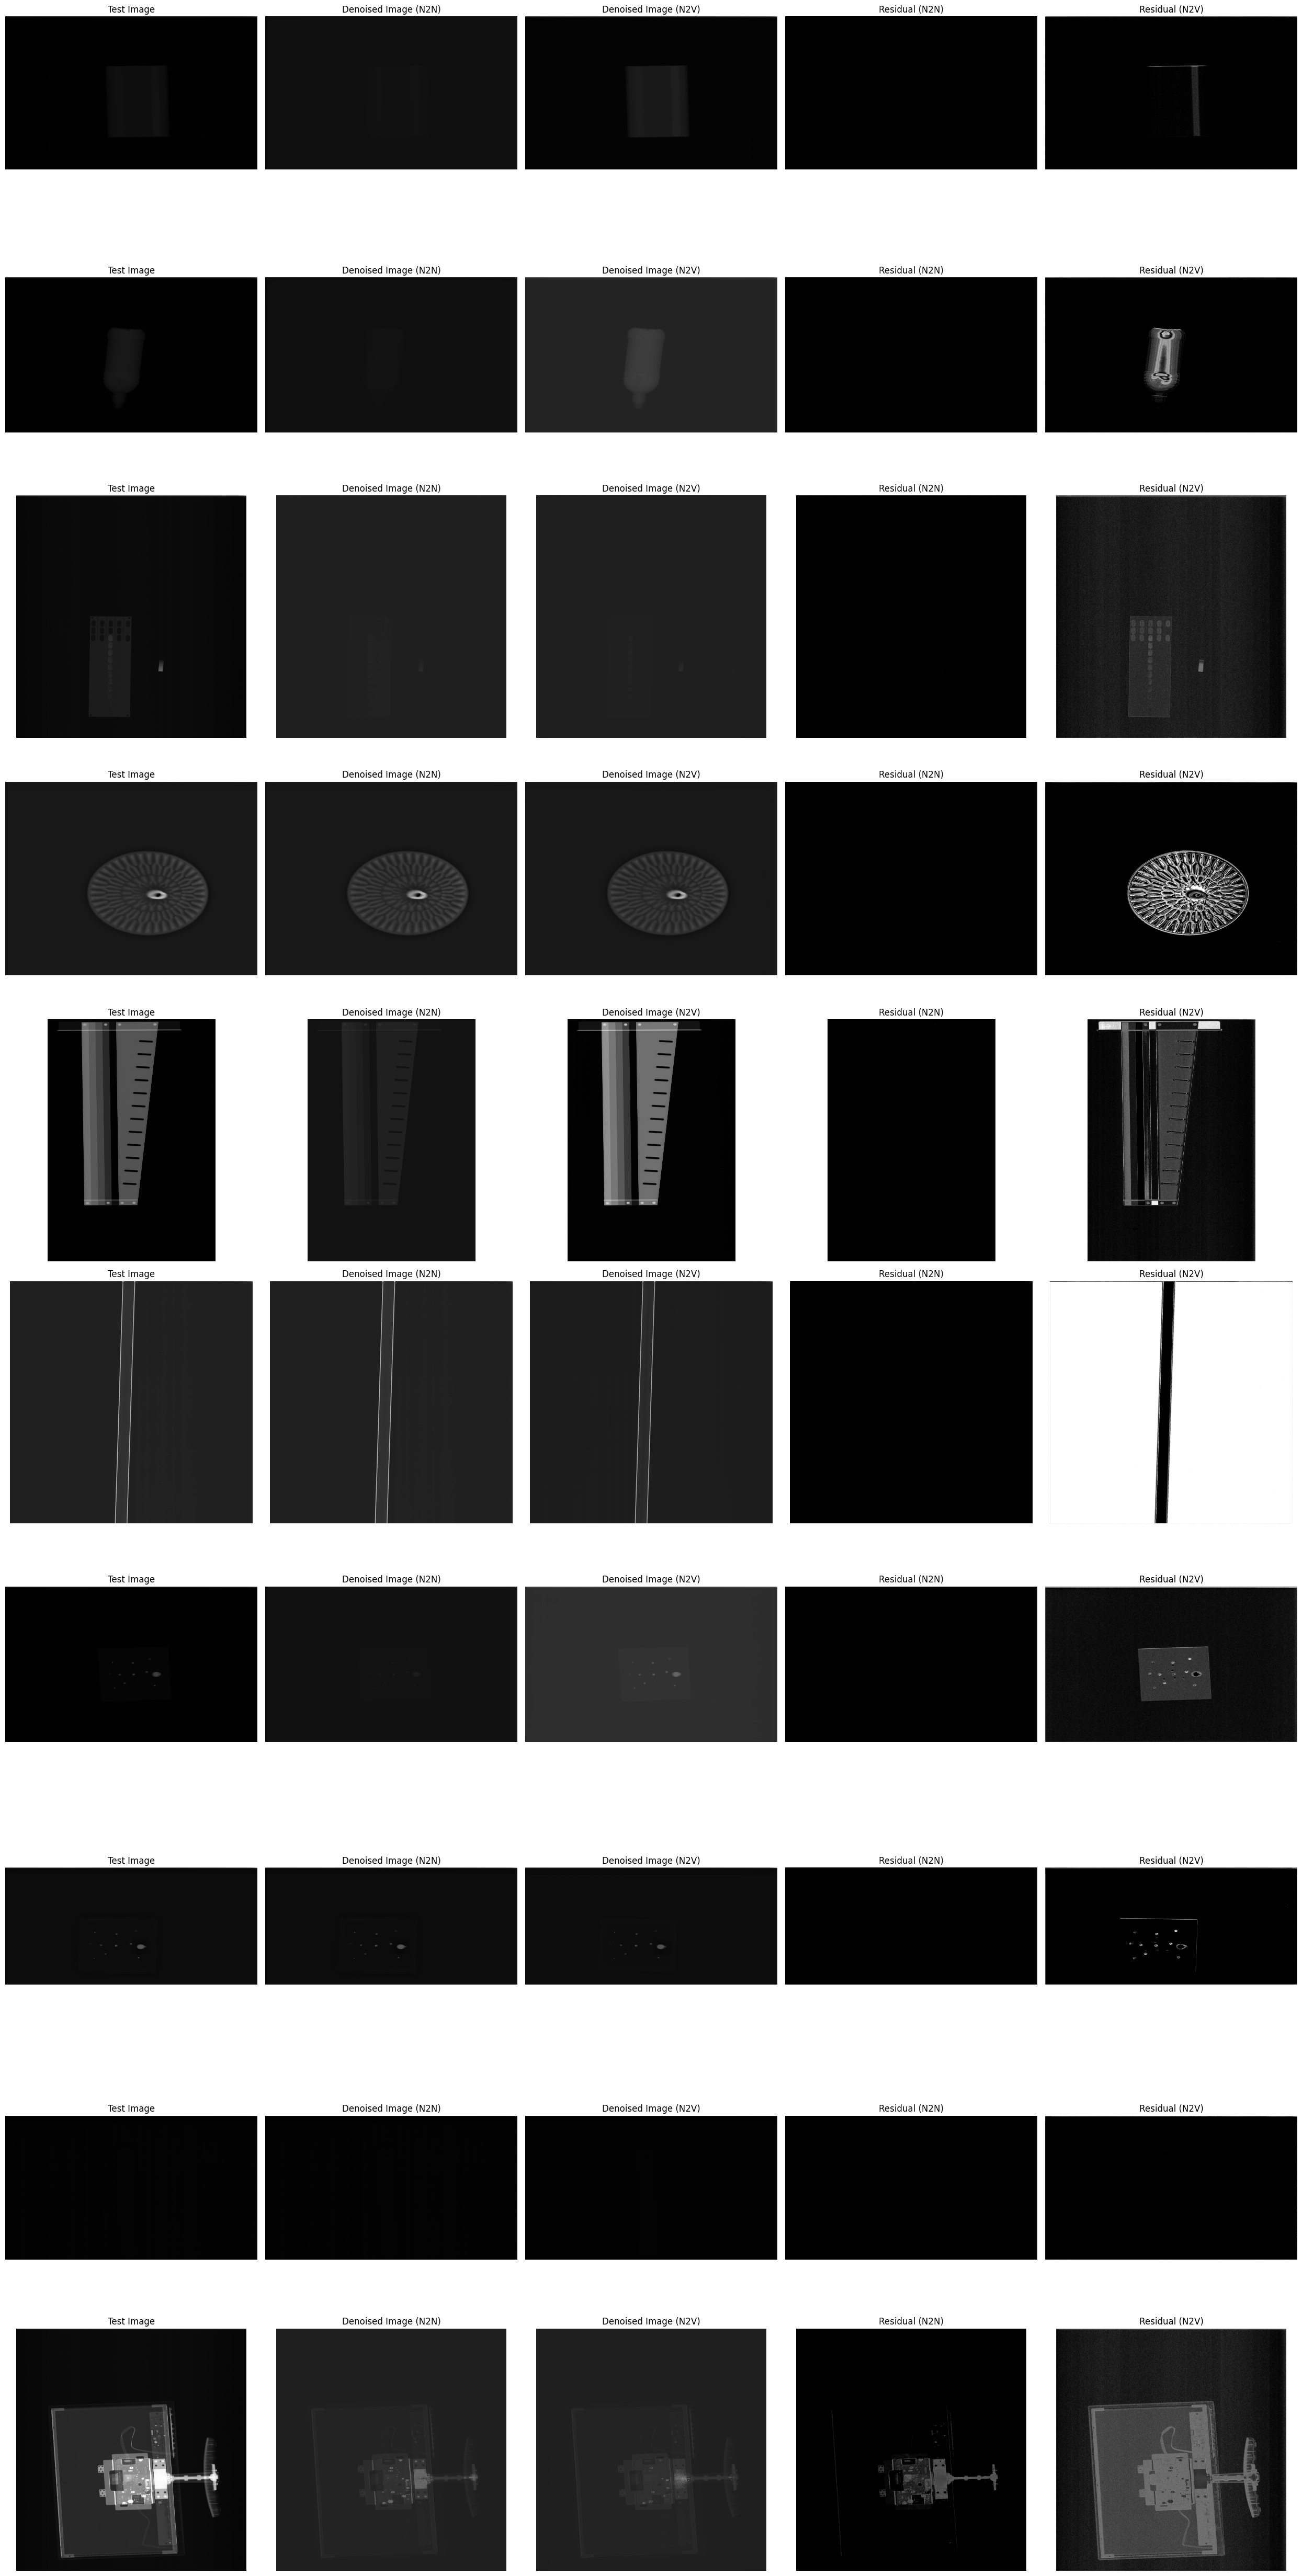

In [104]:
import matplotlib.pyplot as plt

# Assuming testimages, denoisedimages_n2n, denoisedimages_n2v, residuals_n2n, and residuals_n2v are defined

# Plot the images and residuals
fig, axs = plt.subplots(len(testimages), 5, figsize=(25, 5*len(testimages)))

for i in range(len(testimages)):
    # Test Image
    axs[i, 0].imshow(testimages[i], cmap='gray')
    axs[i, 0].set_title('Test Image')
    
    # Denoised Image (N2N)
    axs[i, 1].imshow(denoisedimages_n2n[i], cmap='gray')
    axs[i, 1].set_title('Denoised Image (N2N)')
    
    # Denoised Image (N2V)
    axs[i, 2].imshow(denoisedimages_n2v[i], cmap='gray')
    axs[i, 2].set_title('Denoised Image (N2V)')
    
    # Residual (N2N)
    axs[i, 3].imshow(residuals_n2n[i], cmap='gray')
    axs[i, 3].set_title('Residual (N2N)')
    
    # Residual (N2V)
    axs[i, 4].imshow(residuals_n2v[i], cmap='gray')
    axs[i, 4].set_title('Residual (N2V)')

# Remove axis ticks
for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2. Statistical Analysis


In [106]:
#Calculate the mean and standard deviation of the residuals
mean_residuals_n2n = []
std_residuals_n2n = []

mean_residuals_n2v = []
std_residuals_n2v = []

for i in range(len(testimages)):
    # Calculate the mean and standard deviation of the residual for N2N
    mean_n2n = np.mean(residuals_n2n[i])
    std_n2n = np.std(residuals_n2n[i])
    mean_residuals_n2n.append(mean_n2n)
    std_residuals_n2n.append(std_n2n)
    
    # Calculate the mean and standard deviation of the residual for N2V
    mean_n2v = np.mean(residuals_n2v[i])
    std_n2v = np.std(residuals_n2v[i])
    mean_residuals_n2v.append(mean_n2v)
    std_residuals_n2v.append(std_n2v)

# Create a DataFrame to store the mean and standard deviation of the residuals
data = {'Image': testimagesnames,
        'Mean Residual (N2N)': mean_residuals_n2n,
        'Std Dev Residual (N2N)': std_residuals_n2n,
        'Mean Residual (N2V)': mean_residuals_n2v,
        'Std Dev Residual (N2V)': std_residuals_n2v}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('residuals.csv', index=False)

print(df)

                     Image  Mean Residual (N2N)  Std Dev Residual (N2N)  \
0             Bone_phantom             0.852808               79.037165   
1                   Bottle            27.347747             1250.263827   
2  CT_Phantom_bone_density            20.769098             1099.165494   
3             Glass funnel            10.953602              810.263662   
4                    Metal             1.082338              159.526666   
5              Metal_ruler            24.892960             1258.629715   
6                Phantom_1            30.738848             1334.544822   
7                Phantom_2            20.885457             1141.745656   
8                    Ruler            16.088021              995.755439   
9                   Screen           680.895520             6238.340139   

   Mean Residual (N2V)  Std Dev Residual (N2V)  
0           391.021242             4717.694661  
1          1317.475771             9015.569238  
2          7032.066516     

### 3. 'Frequency Domain' 

In [107]:
def compute_fft(image):
    """Compute the FFT and return the magnitude spectrum"""
    fft = np.fft.fftshift(np.fft.fft2(image))
    return np.log(np.abs(fft) + 1)

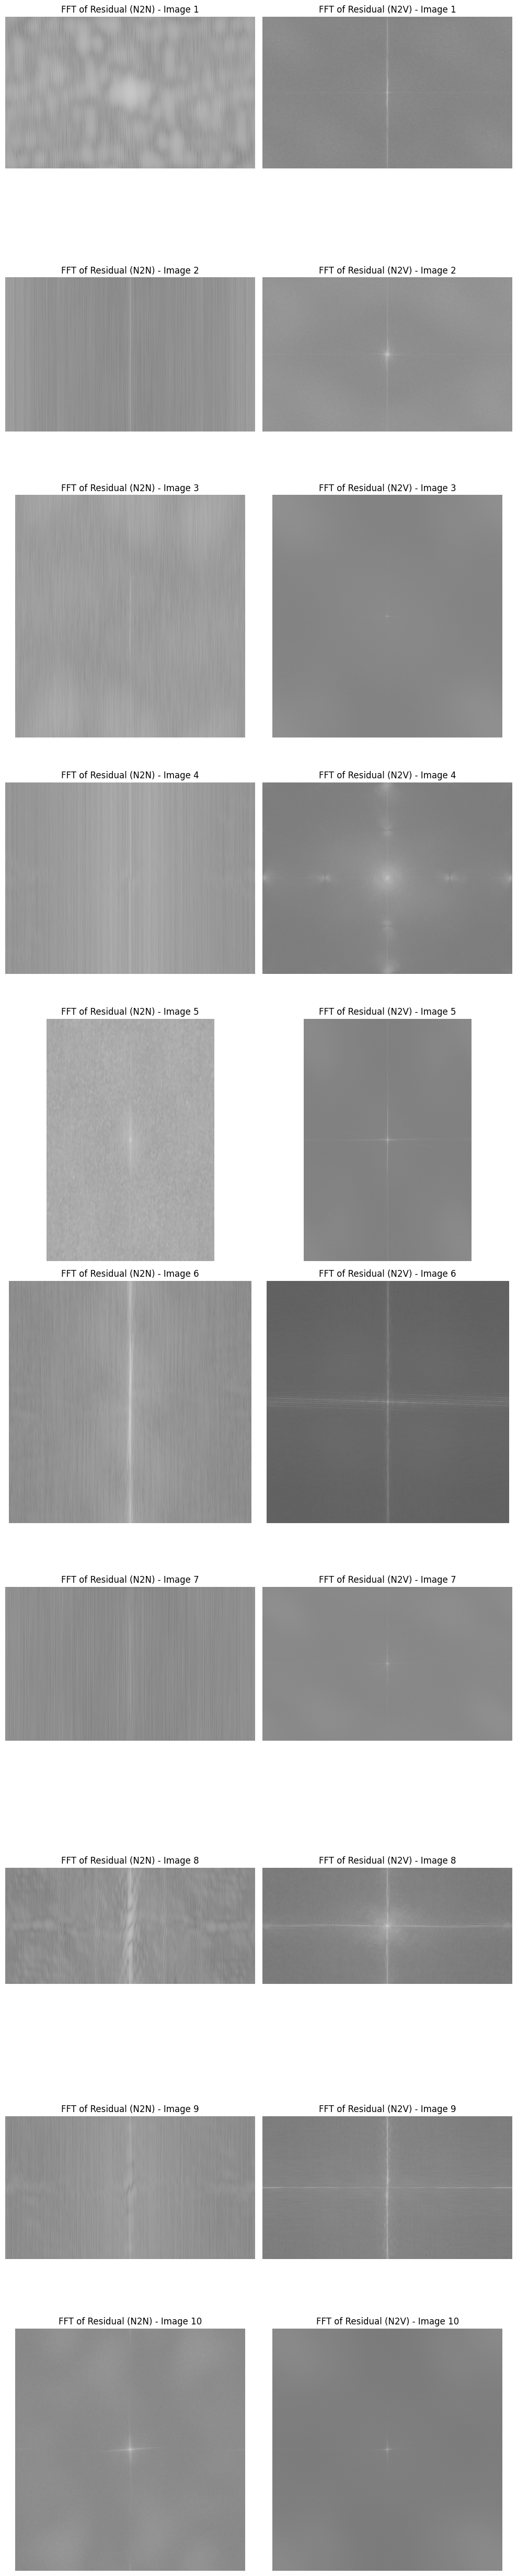

In [108]:
# Plot the FFTs of the residuals
fig, axs = plt.subplots(len(residuals_n2n), 2, figsize=(10, 5*len(residuals_n2n)))

for i in range(len(residuals_n2n)):
    # FFT of Residual (N2N)
    fft_n2n = compute_fft(residuals_n2n[i])
    axs[i, 0].imshow(fft_n2n, cmap='gray')
    axs[i, 0].set_title(f'FFT of Residual (N2N) - Image {i+1}')
    axs[i, 0].axis('off')
    
    # FFT of Residual (N2V)
    fft_n2v = compute_fft(residuals_n2v[i])
    axs[i, 1].imshow(fft_n2v, cmap='gray')
    axs[i, 1].set_title(f'FFT of Residual (N2V) - Image {i+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

### 4. Error Map Analysis

MemoryError: Unable to allocate 826. MiB for an array with shape (54147457, 2) and data type float64

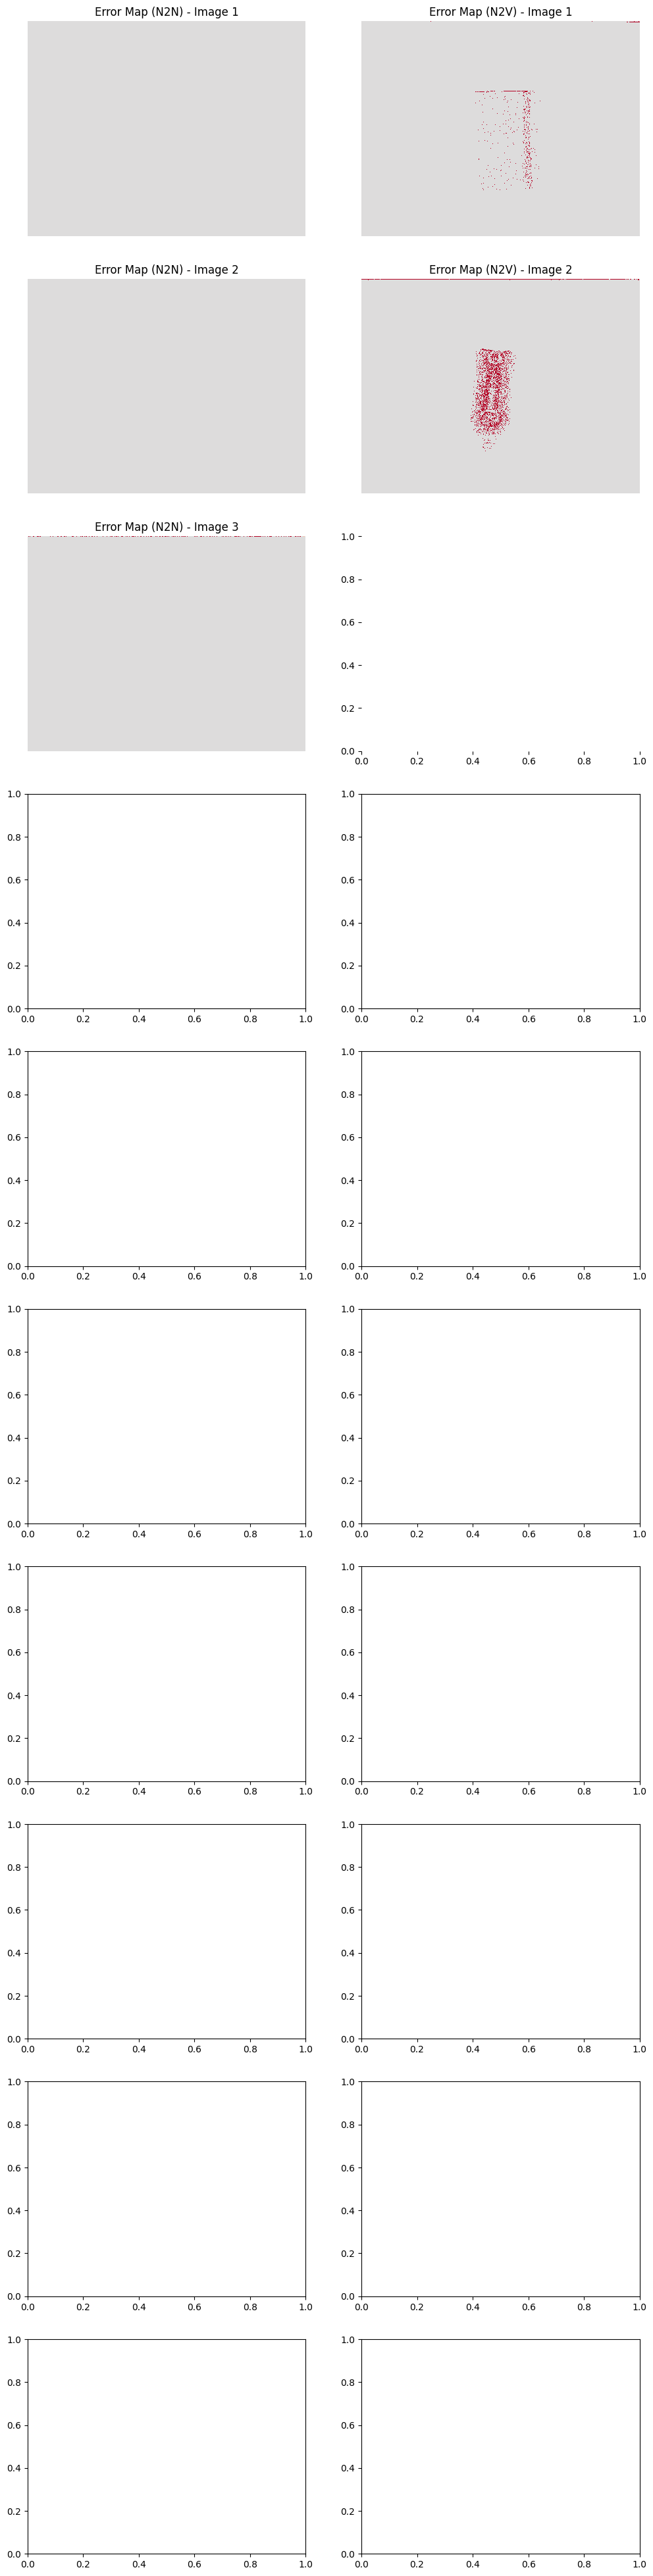

In [109]:

import seaborn as sns

# Assuming residuals_n2n and residuals_n2v are defined

# Plot the error maps of the residuals
fig, axs = plt.subplots(len(residuals_n2n), 2, figsize=(12, 5*len(residuals_n2n)))

for i in range(len(residuals_n2n)):
    # Error Map of Residual (N2N)
    sns.heatmap(residuals_n2n[i], ax=axs[i, 0], cmap='coolwarm', center=0, cbar=False)
    axs[i, 0].set_title(f'Error Map (N2N) - Image {i+1}')
    axs[i, 0].axis('off')
    
    # Error Map of Residual (N2V)
    sns.heatmap(residuals_n2v[i], ax=axs[i, 1], cmap='coolwarm', center=0, cbar=False)
    axs[i, 1].set_title(f'Error Map (N2V) - Image {i+1}')
    axs[i, 1].axis('off')

# Add a common colorbar for the error maps
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-np.abs(residuals_n2n).max(), vmax=np.abs(residuals_n2n).max()))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()